# Modelos de Classificação - Hepatite

In [1]:
# Bibliotecas de manipualção e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Classes dos modelo
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from mord import LogisticAT
from xgboost import XGBClassifier

# Essemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from yellowbrick.classifier import ROCAUC

#SMOTE
from imblearn.over_sampling import SMOTE

#PerC
from perc.src.data.build_dataset import build, normalize
from perc.src.model.classification.perturbation import PerC_Mean, PerC_Covariance, PerC

# Seleção de Features e redução de dimencionalidade
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [2]:
# dataset sem outliers
df_hepatite = pd.read_csv('HCV-Data.csv')

In [3]:
df_hepatite.head()

,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,M,F,Category
0,0,-1.531488,-0.614892,-0.613672,-0.938676,-0.376413,-0.201172,-0.588422,-1.935993,0.492894,-0.503635,-0.660649,1.0,0.0,0
1,1,-1.531488,-0.614892,0.101811,-0.452676,-0.296648,-0.383411,1.368547,-0.520644,-0.151232,-0.436211,0.862461,1.0,0.0,0
2,2,-1.531488,0.941291,0.278672,0.406081,0.559296,-0.272043,0.293137,-0.160045,0.090315,-0.097166,1.431089,1.0,0.0,0
3,3,-1.531488,0.255829,-0.633770,0.141848,-0.361073,0.375918,-0.403803,-0.574734,-0.030458,-0.085607,0.699996,1.0,0.0,0
4,4,-1.531488,-0.485210,0.254555,0.236217,-0.293580,-0.094866,0.436217,-0.953362,-0.110974,-0.160737,-0.721574,1.0,0.0,0


Ao exportar o dataset sem outliers surgiu a coluna `Unnamed: 0` que será removida.

In [4]:
df_hepatite.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df_hepatite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       608 non-null    float64
 1   ALB       608 non-null    float64
 2   ALP       608 non-null    float64
 3   ALT       608 non-null    float64
 4   AST       608 non-null    float64
 5   BIL       608 non-null    float64
 6   CHE       608 non-null    float64
 7   CHOL      608 non-null    float64
 8   CREA      608 non-null    float64
 9   GGT       608 non-null    float64
 10  PROT      608 non-null    float64
 11  M         608 non-null    float64
 12  F         608 non-null    float64
 13  Category  608 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 66.6 KB


In [6]:
corr_df = df_hepatite.corr(method='pearson')

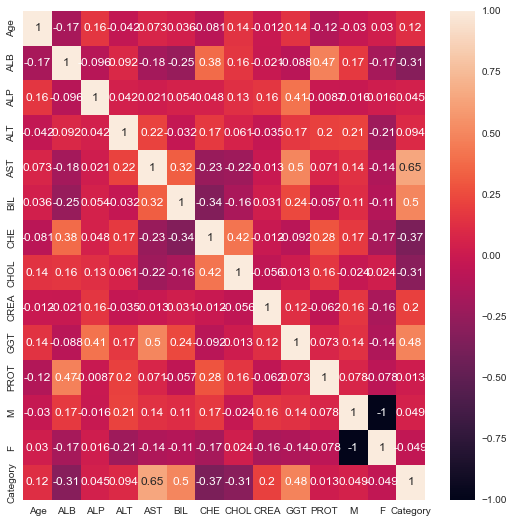

In [7]:
plt.figure(figsize=(9, 9))
sns.heatmap(corr_df, annot=True)
plt.show()

In [8]:
#df_hepatite['Category'] = df_hepatite['Category'].astype('category')

In [9]:
df_hepatite.info()
df_hepatite['Category'] = df_hepatite['Category'].map(lambda x: 1 if x > 0 else 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       608 non-null    float64
 1   ALB       608 non-null    float64
 2   ALP       608 non-null    float64
 3   ALT       608 non-null    float64
 4   AST       608 non-null    float64
 5   BIL       608 non-null    float64
 6   CHE       608 non-null    float64
 7   CHOL      608 non-null    float64
 8   CREA      608 non-null    float64
 9   GGT       608 non-null    float64
 10  PROT      608 non-null    float64
 11  M         608 non-null    float64
 12  F         608 non-null    float64
 13  Category  608 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 66.6 KB


In [10]:
X = df_hepatite[['ALB', 'AST', 'BIL','CHE', 'CHOL', 'GGT']]
y = df_hepatite['Category']

## Hold-out

Antes de realizar o 10-Fold os dados serão separados em treino e teste através do método **hold-out**. O data set de treino será utilizado para validar os modelos e escolher os melhores parâmetros com o **10-fold** para então comparar o modelos com o data set de teste.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=199, stratify=y)

In [12]:
X_train

,ALB,AST,BIL,CHE,CHOL,GGT
22,0.163199,-0.124845,0.603716,1.267006,-0.286255,1.181960
598,-1.633822,0.654401,9.543545,-2.993094,-0.196105,2.081585
365,-1.930238,-0.532876,-0.459344,-1.040741,-0.069896,-0.295584
200,-1.170672,0.043889,-0.196110,1.396240,1.065990,-0.257056
496,0.607823,-0.118710,-0.317603,-0.800735,-0.250195,2.062321
...,...,...,...,...,...,...
359,-0.337002,-0.465382,-0.160675,-1.373056,0.128434,-0.274394
223,0.885713,0.206488,-0.347976,-0.233029,1.390528,-0.322554
321,0.311407,-0.508333,-0.292292,-0.491497,-0.899272,0.122443
356,-0.485210,-0.410160,-0.312540,-1.036125,0.380853,-0.436211


In [13]:
# converte para numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
pd.DataFrame(y_test).value_counts()

0    160
1     23
dtype: int64

# SMOTE

In [15]:
'''
strategy = {1:1500, 2:1500, 3:1500, 4:1500}
oversample = SMOTE(sampling_strategy=strategy)
X_final, y = oversample.fit_resample(X_final, y)
'''

'\nstrategy = {1:1500, 2:1500, 3:1500, 4:1500}\noversample = SMOTE(sampling_strategy=strategy)\nX_final, y = oversample.fit_resample(X_final, y)\n'

## Funções para executar os modelos

In [16]:
#função que retorna um dicionário com os valores dos resultados
def model_results(model, X_train, y_train, X_test, y_test,results_dict_aux):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # medindo e armazenando acurácia e f1-score no dicionário
    # accuracy = model.score(X_test, y_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # AUC = roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')
    CM = confusion_matrix(y_test, y_pred)

    results_dict_aux['accuracy'].append(accuracy)
    results_dict_aux['f1'].append(f1)
    #results_dict_aux['auc'].append(AUC)
    results_dict_aux['cm'].append(CM)
    
    #print(f"f1: %.6f\n" %(f1))
    #print(f"Accuracy: %.6f\n" %(accuracy))
    #print(f"AUC: %.6f" %(AUC))
    #print(f"CM: \n{CM} \n")
    '''
    print("-----------------------CURVA ROC---------------------")
    visualizer = ROCAUC(model, encoder={1:"Class 1", 2:"Class 2", 3:"Class 3", 4:"Class 4"})

    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)        
    visualizer.show()                       
    #print("-----------------------------------------------------\n")'''
    
    return results_dict_aux

## RandomizedSearch

Para cada modelo é implementada uma função do RandomizedSearch. Para ser aplicada em cada um dos 10 conjuntos de treino do 10-fold.

In [17]:
def Random_search(model, param_grid, X, y):

    # defining parameter range
    grid = RandomizedSearchCV(model, param_grid, cv=3,random_state=199, scoring='accuracy', n_jobs=5)
    # fitting the model for grid search
    grid.fit(X, y)
    #utilizando melhores parâmetros calculados pelo gridsearch
    dic_best = grid.best_params_
    
    return dic_best

**KNN**

In [18]:
#dicionário com parêmetros para o gridsearch
knn_param_grid = {
    'n_neighbors': [impar for impar in range(1,32) if (impar%2)!=0],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidian','manhattan','chebyshev']
}

**Decision Tree**

In [19]:
#dicionário com parêmetros para o gridsearch
dt_param_grid = {
    'max_depth': [x for x in range(1,32)],
    'criterion': ['gini', 'entropy'],
}

**MLP**

In [20]:
# dicionário com parêmetros para o gridsearch
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 15, 5), (100, 25, 10)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.1, 0.01, 0.001],
}

**SVM**

In [21]:
#dicionário com parêmetros para o gridsearch
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf','sigmoid', 'linear'], #['linear', 'poly', 'rbf', 'sigmoid']
    'gamma': [1, 0.1, 0.01, 0.001]
}

**Regressão Logística Multimodal**

In [22]:
mlr_param_grid = {
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'sag', 'lbfgs']
}

**Random Forest**

In [23]:
# profundidade máxima
max_depth = [int(x) for x in np.linspace(100, 300, num = 11)]
max_depth.append(None)
# grid
rf_param_grid = {
 'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)],
 'max_depth': max_depth,
 # numero de features a serem consideradas em cada fold
 'max_features': ['auto', 'sqrt', 'log2']
}

**Gradiente Boosting**

In [24]:
gb_param_grid = {
    "loss":["deviance", "exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
}

**Extreme Gradient Boosting**

In [25]:
xgb_param_grid = {
    "objective": ['binary:hinge'],
    "max_depth": range (2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

**Ada Boosting**

In [26]:
ab_param_grid = {
    'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
    'learning_rate':[.001,0.01, 0.1, 1, 2]
}

In [27]:
def calculate_mean_restults(results_dict_models):    
    # a cada interação calcula a média e o desvio padrão da 
    # acurácia, f1-score e matriz de confusão de cada modelo
    for model_key in results_dict_models.keys():
        accuracies = np.array(results_dict_models[model_key]['accuracy'])
        f1 = np.array(results_dict_models[model_key]['f1'])
        #auc = np.array(results_dict_models[model_key]['auc'])
        conf_matrix = np.array(results_dict_models[model_key]['cm'])

        print_mean_result(model_key, accuracies, f1, conf_matrix)

In [28]:
def print_best_results(best_dict_knn, best_dict_dt, best_dict_mlp, best_dict_svm, best_dict_mlr, best_dict_rf, best_dict_xgb, best_dict_gb , best_dict_ab):
    print("\n------- BEST PARAMETERS -------")
    print(f"KNN: {best_dict_knn}")
    print(f"DT: {best_dict_dt}")
    print(f"MLP: {best_dict_mlp}")
    print(f"SVM: {best_dict_svm}")
    print(f"MLR: {best_dict_mlr}")
    print(f"RF: {best_dict_rf}") 
    print(f"XGB: dic:{best_dict_xgb}") 
    print(f"GB: dic:{best_dict_gb}") 
    print(f"AB: dic:{best_dict_ab}")
    print("--------------------------------------------------------------------------")

In [29]:
def print_mean_result(model_key, accuracies, f1, conf_matrix):
    print(f"\t{model_key}")
    print("Acurácia média (desvio): %.6f +- (%.6f)" %(accuracies.mean(), accuracies.std()))
    print("F1-score média (desvio): %.6f +- (%.6f)" %(f1.mean(), f1.std()))
    #print("AUC média (desvio): %.6f +- (%.6f)\n" %(auc.mean(), auc.std()))
    print(f"Matriz de Confusão:  \n{sum(conf_matrix)*0.1}")

## 10-Fold

Com esse método são criados 10 datasets de treino e 10 datasets de test com uma divisão de 90% para treino e 10% para teste em cada divisão.

O conjunto de treino sera divido mais uma vez em treino e validação (isso é feito dendo da função `GridSearchCV` para que então seja aplicado o GridSearch e assim obtenha-se os melhores parâmetros. Por fim, tendo os melhores parâmetros, utiliza-se o conjunto de teste para que se possa avaliar os resultados.

Esses resultados são obtidos de cada fold e então se tira a média deles para obter-se a avaliação final de cada modelo.

In [30]:
#função que roda os modelos em cada uma das divisões do 10-fold
#e imprime a média e o desvio padrão dos resultados

def evaluate_model_with_kfold(kf):
    results_dict_models = {}
    # listas e dicionarios para salvar as métricas dos resultados de todas as interacoes
    # a key 'best'salva a melhor acurácia
    
    results_dict_KNN = {
        'accuracy': [],
        'f1': [],
        #'auc': [],
        'cm': [],
        'best': 0.0
    }
    
    results_dict_PERC = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_DT = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_MLP = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_SVM = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_GNB = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_MLR = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_RF = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_XGB = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_GB = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }
    results_dict_AB = {
        'accuracy': [], 'f1': [],  'cm': [], 'best': 0.0
    }

    
    # váriável para salvar os melhores parâmetros
    best_dict_knn, best_dict_dt, best_dict_mlp, best_dict_svm, best_dict_mlr, best_dict_rf, best_dict_xgb, best_dict_gb , best_dict_ab = {}, {}, {}, {}, {}, {}, {}, {}, {}
    
    fold = 0
    
    # laço que roda todos os modelos em cada 1-fold
    for train, test in kf.split(X_train, y_train):
    
        # usa a lista retornada pelo .split para selicionar as intâncias de cada fold
        X_train_kf = X_train[train,:] 
        y_train_kf = y_train[train]
        X_test_kf = X_train[test,:]
        y_test_kf = y_train[test]
        
        # para acompanhar a execução 
        fold += 1
        print(f"\n{fold}º fold")
        
        #kNN
        print("-KNN")
        dict_knn = Random_search(knn(), knn_param_grid, X_train_kf, y_train_kf)
        model = knn(**dict_knn)
        results_dict_KNN = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_KNN)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_KNN['accuracy'][-1] > results_dict_KNN['best']): 
            results_dict_KNN['best'] = results_dict_KNN['accuracy'][-1]
            best_dict_knn = dict_knn 
            
        #PerC
        print("-PerC")
        model = PerC()
        results_dict_PERC = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_PERC)
            
        #DT
        print("-DT")
        dict_dt = Random_search(DecisionTreeClassifier(), dt_param_grid, X_train_kf, y_train_kf)
        model = DecisionTreeClassifier(**dict_dt, random_state=199)
        results_dict_DT = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_DT)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_DT['accuracy'][-1] > results_dict_DT['best']): 
            results_dict_DT['best'] = results_dict_DT['accuracy'][-1]
            best_dict_dt = dict_dt
        
        
        #MLP 
        print("-MLP")
        dict_mlp = Random_search(MLPClassifier(),mlp_param_grid, X_train_kf,y_train_kf)
        model = MLPClassifier(**dict_mlp, max_iter=2000, tol=0.000001, random_state=199)
        results_dict_MLP = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_MLP)
        #verifica se os parêmetros do fold atual são os melhores comparando a acurácia
        if (results_dict_MLP['accuracy'][-1] > results_dict_MLP['best']): 
            results_dict_MLP['best'] = results_dict_MLP['accuracy'][-1]
            best_dict_mlp = dict_mlp
        
        #GNB 
        print("-GNB")
        model = GaussianNB()
        results_dict_models['GNB'] = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_GNB)
        
        #SVM
        print("-SVM")
        dict_svm = Random_search(SVC(), svm_param_grid, X_train_kf, y_train_kf)
        model = SVC(**dict_svm, probability=True, random_state=199)
        results_dict_SVM = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_SVM)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_SVM['accuracy'][-1] > results_dict_SVM['best']): 
            results_dict_SVM['best'] = results_dict_SVM['accuracy'][-1]
            best_dict_svm = dict_svm           
        
        # Regressão Logística Multimodal
        print("-MLR")
        dict_mlr = Random_search(LogisticRegression(), mlr_param_grid, X_train_kf, y_train_kf)
        model = LogisticRegression(**dict_mlr, multi_class='multinomial', random_state=199)
        results_dict_MLR = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_MLR)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_MLR['accuracy'][-1] > results_dict_MLR['best']): 
            results_dict_MLR['best'] = results_dict_MLR['accuracy'][-1]
            best_dict_mlr = dict_mlr 
        
        # Random Forest
        print("-RF")
        dict_rf = Random_search(RandomForestClassifier(), rf_param_grid, X_train_kf, y_train_kf)
        model = RandomForestClassifier(**dict_rf, random_state=199)
        results_dict_RF = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_RF)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_RF['accuracy'][-1] > results_dict_RF['best']): 
            results_dict_RF['best'] = results_dict_RF['accuracy'][-1]
            best_dict_rf = dict_rf 
      
        # Ada Boosting
        print("-AB")
        dict_ab = Random_search(AdaBoostClassifier(), ab_param_grid, X_train_kf, y_train_kf)
        model = AdaBoostClassifier(**dict_ab, random_state=199)
        results_dict_AB = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_AB)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_AB['accuracy'][-1] > results_dict_AB['best']): 
            results_dict_AB['best'] = results_dict_AB['accuracy'][-1]
            best_dict_ab = dict_ab
      
        # EXtrem Gradiente Boosting
        print("-XGB")
        dict_xgb = Random_search(XGBClassifier(), xgb_param_grid, X_train_kf, y_train_kf)
        model = XGBClassifier(**dict_xgb, random_state=199)
        results_dict_XGB = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_XGB)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_XGB['accuracy'][-1] > results_dict_XGB['best']): 
            results_dict_XGB['best'] = results_dict_XGB['accuracy'][-1]
            best_dict_xgb = dict_xgb
      
        # GB
        print("-GB")
        dict_gb = Random_search(GradientBoostingClassifier(), gb_param_grid, X_train_kf, y_train_kf)
        model = GradientBoostingClassifier(**dict_gb, random_state=199)
        results_dict_GB = model_results(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, results_dict_GB)
        #verifica se os parêmetros do fold atual são os melhores
        if (results_dict_GB['accuracy'][-1] > results_dict_GB['best']): 
            results_dict_GB['best'] = results_dict_GB['accuracy'][-1]
            best_dict_gb = dict_gb        
        
    results_dict_models['KNN'] = results_dict_KNN
    results_dict_models['DT'] = results_dict_DT
    results_dict_models['MLP'] = results_dict_MLP
    results_dict_models['GNB'] = results_dict_GNB
    results_dict_models['SVM'] = results_dict_SVM
    results_dict_models['MLR'] = results_dict_MLR
    results_dict_models['RF'] = results_dict_RF
    results_dict_models['XGB'] = results_dict_XGB
    results_dict_models['GB'] = results_dict_GB
    results_dict_models['AB'] = results_dict_AB
    results_dict_models['PERC'] = results_dict_PERC
    
    # calcula a média dos resultados e imprime cada métrica
    calculate_mean_restults(results_dict_models)

    # imprime os melhores parâmetros
    print_best_results(best_dict_knn, best_dict_dt, best_dict_mlp, best_dict_svm, best_dict_mlr, best_dict_rf, best_dict_xgb, best_dict_ab, best_dict_gb)
    
    # salva os melhores parâmetros em um dicionário que é o retorno da função
    parameters_dict = {
        'knn': best_dict_knn,
        'dt': best_dict_dt,
        'mlp': best_dict_mlp,
        'svm': best_dict_svm,
        'mlr': best_dict_mlr,
        'rf': best_dict_rf,
        'xgb': best_dict_xgb,
        'gb': best_dict_gb,
        'ab': best_dict_ab
    }
    
    return parameters_dict

In [31]:
import warnings

In [32]:
%%time
#ignorando warnings
warnings.filterwarnings('ignore')

params_dict = {}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=199)
params_dict = evaluate_model_with_kfold(skf)


1º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

2º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

3º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

4º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

5º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

6º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

7º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

8º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

9º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB

10º fold
-KNN
-PerC
-DT
-MLP
-GNB
-SVM
-MLR
-RF
-AB
-XGB
-GB
	GNB
Acurácia média (desvio): 0.931894 +- (0.038260)
F1-score média (desvio): 0.930609 +- (0.036607)
Matriz de Confusão:  
[[36.1  1.2]
 [ 1.7  3.5]]
	KNN
Acurácia média (desvio): 0.936489 +- (0.021185)
F1-score média (desvio): 0.924793 +- (0.029434)
Matriz de Confusão:  
[[37.2  0.1]
 [ 2.6  2.6]]
	DT
Acurácia média (desvio): 0.953101 +- (0.027569)
F1-score média (desvio): 0.949766 +- 

## Teste

Aqui os modelos são execultados no dataset de teste com seus melhores parâmetros.

In [33]:
def model_test_results(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #medindo e armazenando acurácia e f1-score no dicionário
    
    #accuracy = model.score(X_test, y_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    #AUC = roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')
    CM = confusion_matrix(y_test, y_pred)
    
    
    print(f"Accuracy: %.6f" %(accuracy))
    print(f"f1: %.6f" %(f1))
    #print(f"AUC: %.6f" %(AUC))
    print(f"CM: \n{CM} \n")
    
    print (classification_report(y_test, y_pred))

In [34]:
pd.DataFrame(y_test).value_counts()

0    160
1     23
dtype: int64

<AxesSubplot:ylabel='count'>

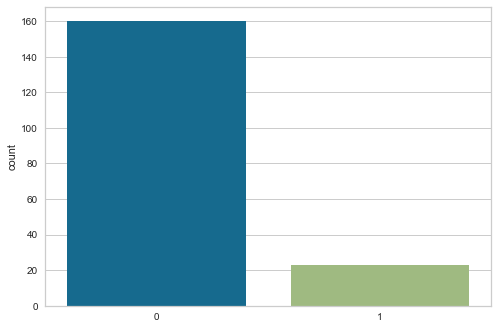

In [35]:
sns.countplot(y_test)

**KNN**

In [36]:
best_param_dict = params_dict['knn']

In [37]:
model = knn(**best_param_dict)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.928962
f1: 0.916356
CM: 
[[160   0]
 [ 13  10]] 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       160
           1       1.00      0.43      0.61        23

    accuracy                           0.93       183
   macro avg       0.96      0.72      0.78       183
weighted avg       0.93      0.93      0.92       183



**PerC**

In [38]:
model = PerC()
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.928962
f1: 0.928283
CM: 
[[154   6]
 [  7  16]] 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       160
           1       0.73      0.70      0.71        23

    accuracy                           0.93       183
   macro avg       0.84      0.83      0.84       183
weighted avg       0.93      0.93      0.93       183



**DT**

In [39]:
best_param_dict = params_dict['dt']

In [40]:
model = DecisionTreeClassifier(**best_param_dict, random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.950820
f1: 0.945511
CM: 
[[160   0]
 [  9  14]] 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       1.00      0.61      0.76        23

    accuracy                           0.95       183
   macro avg       0.97      0.80      0.86       183
weighted avg       0.95      0.95      0.95       183



**MLP**

In [41]:
best_param_dict = params_dict['mlp']

In [42]:
model = MLPClassifier(
            **best_param_dict, 
            max_iter=2000, 
            tol=0.000001,
            random_state=199
        )
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.950820
f1: 0.945511
CM: 
[[160   0]
 [  9  14]] 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       1.00      0.61      0.76        23

    accuracy                           0.95       183
   macro avg       0.97      0.80      0.86       183
weighted avg       0.95      0.95      0.95       183



**GNB**

In [43]:
model = GaussianNB()
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.934426
f1: 0.930112
CM: 
[[157   3]
 [  9  14]] 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       160
           1       0.82      0.61      0.70        23

    accuracy                           0.93       183
   macro avg       0.88      0.79      0.83       183
weighted avg       0.93      0.93      0.93       183



**SVM**

In [44]:
best_param_dict = params_dict['svm']

In [45]:
model = SVC(**best_param_dict, probability=True, random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.956284
f1: 0.952216
CM: 
[[160   0]
 [  8  15]] 

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       160
           1       1.00      0.65      0.79        23

    accuracy                           0.96       183
   macro avg       0.98      0.83      0.88       183
weighted avg       0.96      0.96      0.95       183



**MLR**

In [46]:
best_param_dict = params_dict['mlr']

In [47]:
model = LogisticRegression(**best_param_dict, multi_class='multinomial', random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.956284
f1: 0.952216
CM: 
[[160   0]
 [  8  15]] 

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       160
           1       1.00      0.65      0.79        23

    accuracy                           0.96       183
   macro avg       0.98      0.83      0.88       183
weighted avg       0.96      0.96      0.95       183



**RF**

In [48]:
best_param_dict = params_dict['rf']

In [49]:
model = RandomForestClassifier(**best_param_dict, random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.967213
f1: 0.965056
CM: 
[[160   0]
 [  6  17]] 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       160
           1       1.00      0.74      0.85        23

    accuracy                           0.97       183
   macro avg       0.98      0.87      0.92       183
weighted avg       0.97      0.97      0.97       183



**XGB**

In [50]:
best_param_dict = params_dict['xgb']

In [51]:
model = XGBClassifier(**best_param_dict, random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.967213
f1: 0.965056
CM: 
[[160   0]
 [  6  17]] 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       160
           1       1.00      0.74      0.85        23

    accuracy                           0.97       183
   macro avg       0.98      0.87      0.92       183
weighted avg       0.97      0.97      0.97       183



**Gradient Boost**

In [52]:
best_param_dict = params_dict['gb']

In [53]:
model = GradientBoostingClassifier(**best_param_dict, random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.890710
f1: 0.851890
CM: 
[[160   0]
 [ 20   3]] 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       160
           1       1.00      0.13      0.23        23

    accuracy                           0.89       183
   macro avg       0.94      0.57      0.59       183
weighted avg       0.90      0.89      0.85       183



**Ada Boost**

In [54]:
best_param_dict = params_dict['ab']

In [55]:
model = AdaBoostClassifier(**best_param_dict, random_state=199)
model_test_results(model, X_train, y_train, X_test, y_test)

Accuracy: 0.956284
f1: 0.953408
CM: 
[[159   1]
 [  7  16]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       160
           1       0.94      0.70      0.80        23

    accuracy                           0.96       183
   macro avg       0.95      0.84      0.89       183
weighted avg       0.96      0.96      0.95       183

